### Import dependencies

In [46]:
import os
import shutil
import opendatasets as od
import json
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import librosa as li
import soundfile as sf
from scipy import signal

import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split

### Dataset download and preparation

#### Data preparation function declarations


In [47]:
# Generate butterworth highpass coefficients
def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
    return b, a


# Apply filter to signal
def apply_butter_highpass(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

In [48]:
# Remove sections of silence or low intensity signal
def remove_silence(signal, thresh=18, hop=2048, plot=False):
    splits = li.effects.split(
        y=signal, top_db=thresh, frame_length=(hop * 2), hop_length=hop
    )
    if plot:
        peak = np.max(signal)
        plt.subplots(figsize=(12, 4))
        plt.plot(signal)
        plt.vlines(splits, ymin=-peak, ymax=peak, color='red')
        plt.show()

    stripped_audio = []

    for s in splits:
        split = signal[s[0]: s[1]]
        stripped_audio.extend(split)

    return np.asarray(stripped_audio)

In [49]:
# Split audio into segments of desired length
def split_audio(signal, target_length, samplerate, plot=False):
    duration = li.get_duration(y=signal, sr=samplerate)
    n_segments = np.ceil(duration / target_length)
    audio_segments = []

    for n in range(int(n_segments)):
        s = signal[
            samplerate * n * target_length: samplerate * (n + 1) * target_length
        ]

        if len(s) < target_length * samplerate:
            s = np.pad(s, (0, target_length * samplerate - len(s)), 'constant')

        audio_segments.append(s)

        if plot:
            plt.plot(s, alpha=1 / n_segments)

    if plot:
        plt.show()

    return audio_segments

In [50]:
# Apply all signal processing functions to audio and return segments
def generate_preprocessed_samples(path, sr, length, hp=700):

    y, sr = li.load(path, sr=sr, mono=True)  # Load audio file

    y = apply_butter_highpass(
        data=y, cutoff=hp, fs=sr, order=5
    )  # Apply high-pass filter

    # Delete silent sections
    y = remove_silence(y, thresh=18, hop=2048, plot=False)

    audio_segments = split_audio(
        y, target_length=length, samplerate=sr
    )  # Split into segments of desired length

    return audio_segments

#### Dataset download


In [51]:
dataset_url = (
    'https://www.kaggle.com/datasets/rtatman/british-birdsong-dataset?resource=download'
)
dowload_path = '..\\datasets\\'

od.download(dataset_url, data_dir=dowload_path)

dataset_path = dowload_path + 'british-birdsong-dataset\\'

100%|██████████| 633M/633M [00:25<00:00, 26.0MB/s] 


In [53]:
# Parse metadata csv
metadata = pd.read_csv(
    dataset_path + 'birdsong_metadata.csv',
    usecols=['file_id', 'genus', 'species', 'english_cname'],
)

#### Audio data samples preparation

User defined constants for audio preparation.

In [54]:
# Target sample rate for resampling audio files
SAMPLE_RATE = 16000

# Target length for audio segments (in seconds)
SAMPLE_LENGTH = 3

Read all audio files from directory, apply filter, remove silent sections and split into segments. Save each segment to disk, with filename according to scientific bird name corresponding to dataset metadata.

In [55]:
old_path = dataset_path + 'songs\\songs\\'
audio_path = dataset_path + 'audio\\'

try:
    os.mkdir(audio_path)
    print('Created new folder: ' + audio_path)
except:
    print(audio_path + ' already exists\n')

for file in os.listdir(old_path):
    id = file.lstrip('xc').rstrip('.flac')
    data = metadata.loc[metadata['file_id'] == int(id)]

    name = data['genus'].item() + '_' + data['species'].item()
    subfolder = audio_path + name + '\\'
    try:
        os.mkdir(subfolder)
    except:
        pass

    # Preprocess audio and get segments of desired length
    audio_segments = generate_preprocessed_samples(
        old_path + file, sr=SAMPLE_RATE, length=SAMPLE_LENGTH
    )

    # Iterate through splitted audio segments and save each one as a separate flac file
    for i, segment in enumerate(audio_segments):
        new_filename = f'{subfolder}{name}_{id}_{i}.flac'
        sf.write(new_filename, segment, SAMPLE_RATE,
                 format='flac', subtype='PCM_16')

shutil.rmtree(dataset_path + '\\songs')

print('Finished generating audio samples!')

Created new folder: ..\datasets\british-birdsong-dataset\audio\
Finished generating audio samples!


### Preprocess dataset


In [56]:
# Get dataset path
dataset_path = '..\\datasets\\british-birdsong-dataset\\'
# Get audio path
audio_path = dataset_path + "audio\\"

Read samples from disk and store file path, label, labels mapping and MFCC data into JSON file.

In [61]:
def preprocess_audio_dataset(data_path, json_path=None, mfcc_count=13, hop=512, fft_len=2048):
    data_dict = {
        'label_map': [],
        'encoded_labels': [],
        'mfccs': [],
        'files': [],
    }

    for i, (path, _, files) in enumerate(os.walk(data_path)):
        if path == data_path:  # Ignore parent folder
            continue

        # Add unique labels to label_map list
        label = path.split('\\')[-1]
        if label not in data_dict['label_map']:
            data_dict['label_map'].append(label)

        for f in files:
            # Add encoded label to encoded_labels list
            index = data_dict['label_map'].index(label)
            data_dict['encoded_labels'].append(index)

            # Add file path to files list
            data_dict['files'].append(os.path.join(path, f))

            # Load audio and add MFCCs to list
            y, sr = li.load(os.path.join(path, f), sr=None, mono=True)
            mfccs = li.feature.mfcc(y=y, sr=sr, n_mfcc=mfcc_count, hop_length=hop, n_fft=fft_len)

            # Cast np.array to list is needed to save as JSON file
            data_dict['mfccs'].append(mfccs.transpose().tolist())

    # Store in json file
    if json_path:
        with open(json_path, 'w') as jf:
            json.dump(data_dict, jf, indent=4)
            print(f'Successfully saved preprocessed data to {json_path}!')
            file_count = len(data_dict['files'])
            print(f'{file_count} audio samples were processed!')
    # return data_dict

In [62]:
json_path = dataset_path + 'preprocessed_data.json'
preprocess_audio_dataset(audio_path, json_path=json_path, mfcc_count=25)

Successfully saved preprocessed data to ..\datasets\british-birdsong-dataset\preprocessed_data.json!
7401 audio samples were processed!


### Build and train CNN model

#### Read JSON data and generate train/test/validation splits

In [31]:
def generate_splits(data_path, val_split=0.3, test_split=0.1):
    # Read JSON and extract X and Y values
    with open(data_path, 'r') as jf:
        data = json.load(jf)
    x = np.array(data['mfccs'])
    y = np.array(data['encoded_labels'])
    label_map = data['label_map']

    # Generate splits
    x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=val_split)
    x_val, x_test, y_val, y_test = train_test_split(x_val, y_val, test_size=test_split)

    # Add third dimension to MFCC arrays
    x_train = x_train[..., np.newaxis]
    x_test = x_test[..., np.newaxis]
    x_val = x_val[..., np.newaxis]

    return x_train, x_test, x_val, y_train, y_test, y_val, label_map

In [36]:
json_path = '..\\datasets\\british-birdsong-dataset\\preprocessed_data.json'

x_train, x_test, x_val, y_train, y_test, y_val, label_map = generate_splits(json_path)

print(
    f'• Train dataset: {x_train.shape[0]} files \n• Validation dataset: {x_val.shape[0]} files \n• Test dataset: {x_test.shape[0]} files'
)

• Train dataset: 1793 files 
• Validation dataset: 692 files 
• Test dataset: 77 files


#### Define and compile the model

In [63]:
LEARNING_RATE = 0.0001,
BATCH_SIZE = 32
EPOCHS = 60

In [64]:
input_shape = (x_train.shape[1], x_train.shape[2], x_train.shape[3])
class_count = len(label_map)

#TODO: add and test data augmentation layers

model = keras.models.Sequential(
    [
        keras.layers.InputLayer(input_shape=input_shape),
        # Convolution layer 1
        keras.layers.Conv2D(
            filters=64,
            kernel_size=(3, 3),
            activation='relu',
            kernel_regularizer=keras.regularizers.l2(0.001),
        ),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding='same'),
        # Convolution layer 2
        keras.layers.Conv2D(
            filters=32,
            kernel_size=(3, 3),
            activation='relu',
            kernel_regularizer=keras.regularizers.l2(0.001),
        ),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding='same'),
        # Convolution layer 3
        # keras.layers.Conv2D(
        #     filters=32,
        #     kernel_size=(2, 2),
        #     activation='relu',
        #     kernel_regularizer=keras.regularizers.l2(0.001),
        # ),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
        # Dense layer
        keras.layers.Flatten(),
        keras.layers.Dense(units=128, activation='relu'),
        keras.layers.Dropout(0.4),
        # Classification layer
        keras.layers.Dense(units=class_count, activation='softmax'),
    ]
)

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 92, 23, 64)        640       
                                                                 
 batch_normalization_15 (Bat  (None, 92, 23, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 46, 12, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 44, 10, 32)        18464     
                                                                 
 batch_normalization_16 (Bat  (None, 44, 10, 32)       128       
 chNormalization)                                                
                                                      

In [65]:
# TODO: find a way to update learning rate dynamically
optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE)

# TODO: add corresponding metrics
metrics = []

model.compile(optimizer='Adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [66]:
# TODO: add callbacks
callbacks = []

history = model.fit(x_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(x_val, y_val), callbacks=callbacks)

Epoch 1/60
57/57 [==============================] - 4s 56ms/step - loss: 3.7755 - accuracy: 0.2131 - val_loss: 3.7290 - val_accuracy: 0.2197
Epoch 2/60
57/57 [==============================] - 3s 57ms/step - loss: 2.6296 - accuracy: 0.3971 - val_loss: 2.4391 - val_accuracy: 0.4668
Epoch 3/60
57/57 [==============================] - 3s 60ms/step - loss: 1.9702 - accuracy: 0.5365 - val_loss: 2.0696 - val_accuracy: 0.5260
Epoch 4/60
57/57 [==============================] - 3s 58ms/step - loss: 1.4972 - accuracy: 0.6241 - val_loss: 1.6642 - val_accuracy: 0.6199
Epoch 5/60
57/57 [==============================] - 3s 54ms/step - loss: 1.1501 - accuracy: 0.7083 - val_loss: 1.4578 - val_accuracy: 0.6474
Epoch 6/60
57/57 [==============================] - 3s 56ms/step - loss: 1.0185 - accuracy: 0.7446 - val_loss: 1.4298 - val_accuracy: 0.6590
Epoch 7/60
57/57 [==============================] - 3s 57ms/step - loss: 0.9660 - accuracy: 0.7552 - val_loss: 1.3141 - val_accuracy: 0.6965
Epoch 8/60
57

#### Plot model accuracy and loss graphs

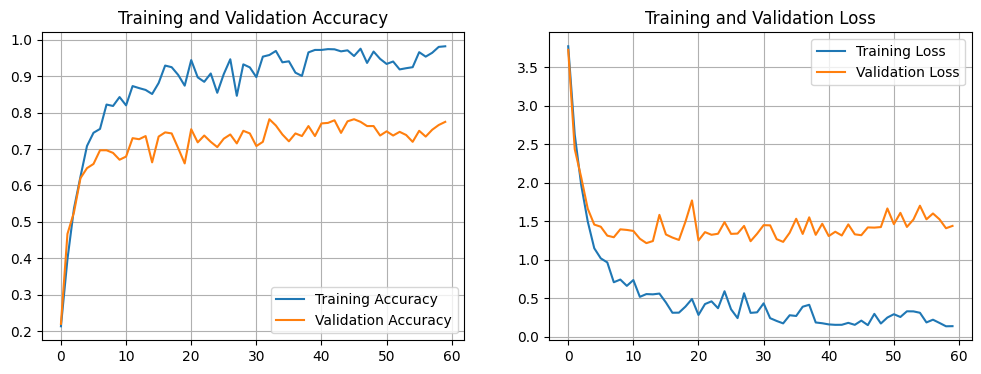

In [67]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs_range = range(EPOCHS)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Training Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.grid()
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.grid()
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")

figure = plt.gcf()
plt.show()

### TO-DO:
- Test different segment length (1s)
- Test different values for conv layers
- Test different amount of neurons for dense layers
- Noise/reverb/distortion/etc audio data augmentation in data preparation stage
- Test MFCC vs mel spectrogam performance
    - Add spectrogram generation and file saving in data preparation stage
- Try to implement a LSTM model and compare results to CNN